In [1]:
import mcstasscript as ms
my_configurator = ms.Configurator()
my_configurator.set_mcrun_path("/usr/bin/")
my_configurator.set_mcstas_path("/usr/share/mcstas/3.4/")

In [2]:
instrument = ms.McStas_instr("my_instrument")
L0=2.165
DL=0.02
By=4.68e-3
AnaSign=1

In [3]:
instrument.available_components()

Here are the available component categories:
 contrib
 misc
 monitors
 obsolete
 optics
 samples
 sources
 union
Call available_components(category_name) to display


In [4]:
source = instrument.add_component("source", "Source_simple")
source.show_parameters()

 ___ Help Source_simple _____________________________________________________________
|optional parameter|required parameter|default value|user specified value|
radius = 0.1 [m] // Radius of circle in (x,y,0) plane where neutrons are 
                    generated. 
yheight = 0.0 [m] // Height of rectangle in (x,y,0) plane where neutrons are 
                     generated. 
xwidth = 0.0 [m] // Width of rectangle in (x,y,0) plane where neutrons are 
                    generated. 
dist = 0.0 [m] // Distance to target along z axis.
focus_xw = 0.045 [m] // Width of target
focus_yh = 0.12 [m] // Height of target
E0 = 0.0 [meV] // Mean energy of neutrons.
dE = 0.0 [meV] // Energy half spread of neutrons (flat or gaussian sigma).
lambda0 = 0.0 [AA] // Mean wavelength of neutrons.
dlambda = 0.0 [AA] // Wavelength half spread of neutrons.
flux = 1.0 [1/(s*cm**2*st*energy unit)] // flux per energy unit, Angs or meV if 
                                           flux=0, the source emits 1 in 4*

In [5]:
source.yheight = 0.01
source.xwidth = 0.01
source.dist = 5
source.focus_xw = 0.01
source.focus_yh = 0.01
source.lambda0 = 2.165
source.dlambda = 2.2
gauss=1
print(source)

COMPONENT source = Source_simple(
  yheight = 0.01, // [m]
  xwidth = 0.01, // [m]
  dist = 5, // [m]
  focus_xw = 0.01, // [m]
  focus_yh = 0.01, // [m]
  lambda0 = 2.165, // [AA]
  dlambda = 2.2 // [AA]
)
AT (0, 0, 0) ABSOLUTE


In [6]:
wavelength = instrument.add_parameter("wavelength", value=L0, comment="Wavelength in AA")
delta_wavelength = instrument.add_parameter("delta_wavelength", value=DL, comment="Stdev of Wavelength in AA")
By = instrument.add_parameter("By", value=By, comment="Flipper field strength in Y direction (?)")

source.lambda0 = wavelength
source.dlambda = delta_wavelength
print(source)

COMPONENT source = Source_simple(
  yheight = 0.01, // [m]
  xwidth = 0.01, // [m]
  dist = 5, // [m]
  focus_xw = 0.01, // [m]
  focus_yh = 0.01, // [m]
  lambda0 = wavelength, // [AA]
  dlambda = delta_wavelength // [AA]
)
AT (0, 0, 0) ABSOLUTE


In [7]:
set_pol = instrument.add_component("set_pol", "Set_pol")
set_pol.set_parameters(px=1)
set_pol.set_AT(0.01, RELATIVE=source)

In [8]:
f1 = instrument.add_component("f1","Foil_flipper_magnet")
f1.set_parameters(
    xwidth=0.1, 
    yheight=0.1, 
    zdepth=0.3, 
    phi=0.095993, 
    foilthick=3.0, 
    Bx=0, 
    By=By, 
    Bz=0, 
    foil_in=1, verbose=0
)
f1.set_AT(1.0, RELATIVE=source)

In [9]:
f2 = instrument.copy_component("f1")
f2.set_AT(3.0, RELATIVE=source)
# Todo: remove this, make it unnecessary
By=4.68e-3

f2.set_parameters(By=2 * By)


In [10]:
ana = instrument.add_component("ana","PolAnalyser_ideal")
ana.set_parameters(mx=AnaSign)
ana.set_AT(0.18, RELATIVE=f2)


In [11]:
sans_spheres = instrument.add_component("sans_sample", "SANS_spheres2")

In [12]:
sans_spheres.set_AT(0.2, RELATIVE=f2)
sans_spheres.set_parameters(xwidth=0.02, 
    yheight=0.02, 
	zthick=0.001, 
	dsdw_inc=0.0, 
	sc_aim=0.8, 
	sans_aim=0.95, 
	R=10000, 
	phi=0.015, 
	singlesp=0,
	Qmind = 0.00003,
	Qmaxd = 0.001)
print(sans_spheres)


In [13]:
PSD = instrument.add_component("PSD", "PSD_monitor")
PSD.set_AT([0, 0, 5], RELATIVE=source)
PSD.set_parameters(xwidth=0.011, yheight=0.011 ,ny=1001, nx=1, filename='"PSD.dat"')

In [14]:
instrument.show_parameters()

 wavelength        = 2.165    // Wavelength in AA
 delta_wavelength  = 0.02     // Stdev of Wavelength in AA
 By                = 0.00468  // Flipper field strength in Y direction (?)


In [15]:
instrument.settings(mpi=4, ncount=1E8)

In [16]:
data = instrument.backengine()


/usr/share/mcstas/3.4/tools/Python/mcrun/mcrun.py:450: SyntaxWarning: invalid escape sequence '\w'
  params = re.findall('[\w0-9]+=[^=\s]+', text)
/usr/share/mcstas/3.4/tools/Python/mcrun/mccode.py:328: SyntaxWarning: invalid escape sequence '\ '
  ''' Escape \ and " '''
INFO: Using directory: "/home/tbvanderwoude/repos/bep/my_instrument_7"
INFO: Regenerating c-file: my_instrument.c
Info:    'Foil_flipper_magnet' is a contributed component.
CFLAGS=

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
INFO: Recompiling: ./my_instrument.out
./my_instrument.c: In function ‘Table_Read_Handle’:
./my_instrument.c:7220:60: warning: format ‘%i’ expects argument of type ‘int’, but argument 5 has type ‘long int’ [-Wformat=]
 7220 |       fprintf(stderr,"Warning: Read_Tab

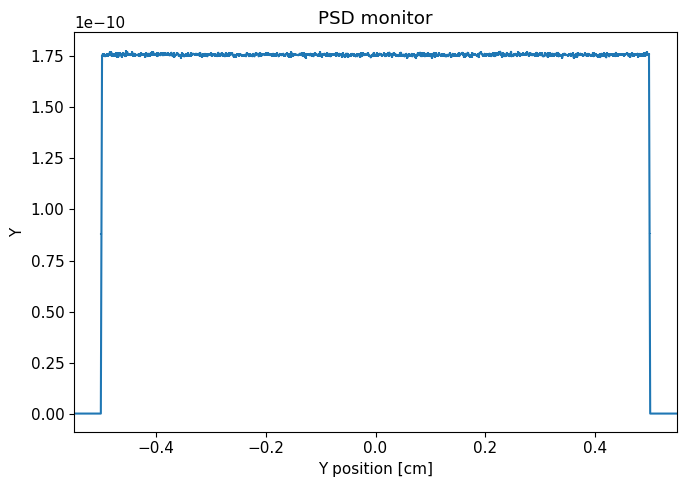

In [18]:
ms.make_sub_plot(data, log=False)


In [194]:
print(data)

[
McStasData: PSD type: 1D  I:7.80887e-08 E:1.5713e-11 N:95217200.0]


In [195]:
PSD_data = ms.name_search("PSD", data)

In [196]:
PSD_data.Intensity

array([1.15556401e-14, 1.66157581e-14, 1.32921256e-14, ...,
       4.49675070e-14, 4.47478970e-14, 4.66021645e-14])